In [1]:
import os
import math
import numpy as np
import pandas as pd
import sklearn.datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from models import MLP

In [2]:
def load_data_sample():
    data_sample, _ = sklearn.datasets.make_swiss_roll(n_samples = batch_size, noise=0)
    data_sample = data_sample[:, [0, 2]]
    data_sample = data_sample / data_sample.std()
    return torch.Tensor(data_sample)

def load_prior_sample():
    return torch.randn(batch_size, 2)

In [3]:
def rectified_flow(
    v_model, 
    prior_sample, 
    num_steps, 
):
    batch_size = prior_sample.shape[0]
    
    step_size = 1 / num_steps
    
    prior_cache = []
    prior_at_t = prior_sample
    prior_cache.append(prior_at_t)
    for t in np.linspace(0, 1, num_steps, endpoint = False):
        t_embedding = torch.ones((batch_size, 1)).cuda() * num_steps * step_size
        v = v_model(prior_at_t, t_embedding)
        prior_at_t = prior_at_t + v * step_size
        prior_cache.append(prior_at_t)
        
    prior_cache = torch.stack(prior_cache, dim = 0)
    
    return prior_cache

def rf_train_one_step(
    v_model, 
    v_model_opt, 
    data_sample, prior_sample, 
):
    # sample shape: (batch, ...)
    
    assert data_sample.shape == prior_sample.shape
    
    v_model_opt.zero_grad()
    
    ### Training velocity model
    
    batch_size = data_sample.shape[0]
    
    t_shape = [batch_size if ii == 0 else 1 for ii in range(len(data_sample.shape))]
    
    t = torch.rand(*t_shape).cuda()
    
    mixed = t * data_sample + (1 - t) * prior_sample
    
    t_embeddings = t.reshape(batch_size, -1)
    
    pred = v_model(mixed, t_embeddings)
    
    diff = data_sample - (prior_sample + pred)
    loss = torch.square(diff).mean()
    
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(v_model.parameters(), 0.5)
    v_model_opt.step()

    v_model_opt.zero_grad()
    
    return loss.detach().cpu().numpy().item()

In [4]:
epochs = 10_000

batch_size = 2048

lr = 1e-3

v_model = MLP(2, 1, 64, 4, step_size = None)

v_model.cuda()

v_model_opt = optim.Adam(v_model.parameters(), lr=lr)

pbar = tqdm(total = epochs, position=0, leave=True)

history = []
model_cache = []

train_log = {"loss": np.nan}

for epoch in range(epochs):
    
    prior_sample = load_prior_sample().cuda()
    data_sample = load_data_sample().cuda()

    loss = rf_train_one_step(
        v_model, 
        v_model_opt, 
        data_sample, prior_sample, 
    )
    train_log = {"loss": loss}
    history.append(train_log)
    pbar.set_postfix(train_log)
        
    model_cache.append(v_model)
    
    pbar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
history_df = pd.DataFrame(history)

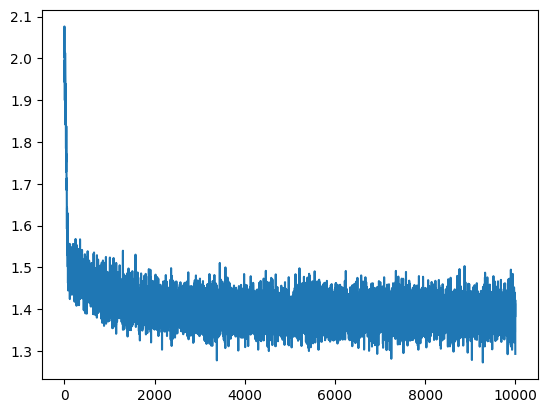

In [6]:
plt.plot(history_df["loss"])
plt.show()

In [7]:
num_steps = 10000
step_size = 1 / num_steps

prior_sample = torch.randn(batch_size, 2).cuda()

cache = rectified_flow(v_model, prior_sample, num_steps)

cache = cache.detach().cpu().numpy()

In [8]:
cache.shape

(10001, 2048, 2)

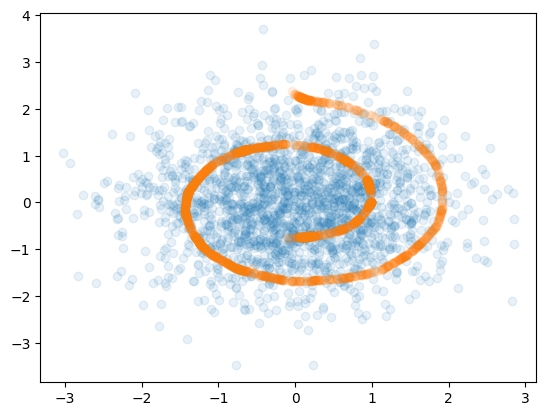

In [9]:
t = -1

# plt.scatter(data_sample[:, 0].cpu(), data_sample[:, 1].cpu(), alpha = 0.1)
plt.scatter(cache[0, :, 0], cache[0, :, 1], alpha = 0.1)
plt.scatter(cache[t, :, 0], cache[t, :, 1], alpha = 0.1)

plt.show()